# Argosim tutorial - Part 4

In this tutorial we will explore the `clean` module. This module implements the Hogbom Clean algorithm.

In [7]:
from argosim import antenna_utils  
from argosim import imaging_utils  
from argosim import metrics_utils  
from argosim import plot_utils  
from argosim import data_utils  

import numpy as np
import matplotlib.pyplot as plt

Take a look at the loaded modules and check the functions available in the modules we haven't explored yet.

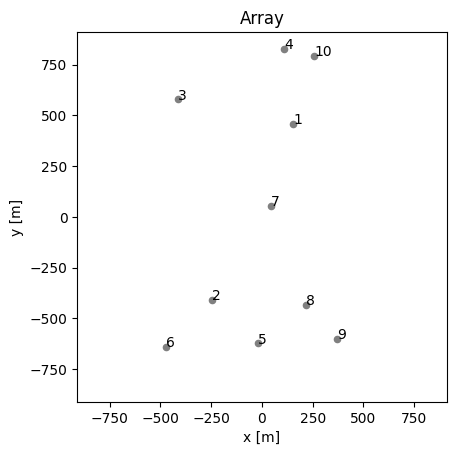

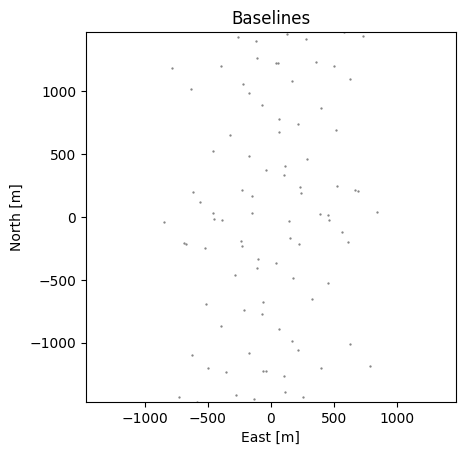

In [122]:
from argosim import antenna_utils 
# Create an antenna array with 5 antennas randomly distributed in a 1x2 km area.

random_array_5 = antenna_utils.random_antenna_arr(n_antenna=10, E_lim= 1000, N_lim=2000)

plot_utils.plot_antenna_arr(random_array_5)

# Compute the baselines and the uv-tracks.
baselines= antenna_utils.get_baselines(random_array_5)

# Plot the baselines.

plot_utils.plot_baselines(baselines, ENU=True) 



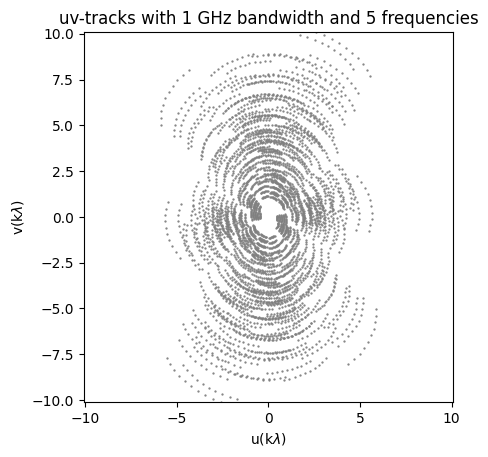

In [137]:
# Compute the uv-sampling tracks for the following parameters:
# Latitude = 20 degrees
# Declination = 45 degrees
# Track time = 3 hours
# Start time = -1 hours
# Number of time samples = 10
# Frequency = 1.5 GHz
# Bandwidth = 1 GHz
# Number of frequency channels = 5

latitude= np.deg2rad(20)    
source_declination = np.deg2rad(45)  

track_time = 3  # in hours 
t_0 = -1    
n_times = 10         
freq = 1.5e9
bandwidth = 1e9 
df= bandwidth
n_freqs = 5

# Compute the uv-tracks

uv_tracks = antenna_utils.uv_track_multiband(baselines, lat=latitude, dec=source_declination, track_time=track_time, t_0=t_0, n_times=n_times, f=freq, df=df,n_freqs=n_freqs, multi_band=False)[0]

# Plot the baselines and the uv-tracks using the plot_utlis module.

plot_utils.plot_baselines(uv_tracks,ENU=False)
plt.title("uv-tracks with 1 GHz bandwidth and 5 frequencies")
plt.show()



### Simulate the sky model
We will start by simulating a sky model. We will use the `data_utils` module from argosim. 

Check the function `n_source_sky` from the `data_utils` module. 

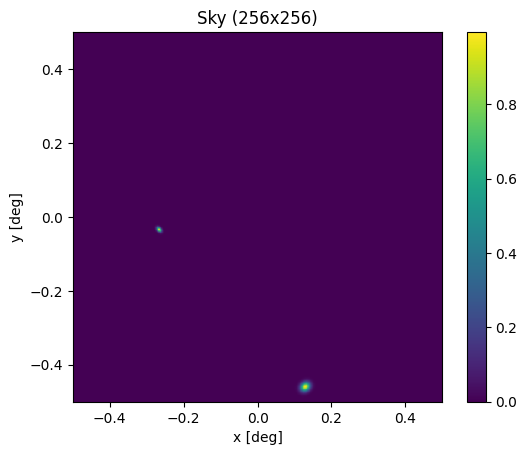

In [124]:
# Create the sky model using argosim.data_utils.n_source_sky()
im_size = (256,256)
fov = .5 # degrees
fov_size = (fov, fov)
sky_model = data_utils.n_source_sky(im_size, fov, [0.01, 0.005], [1., 1.])

# Plot the sky model
plot_utils.plot_sky(sky_model)


Text(0.5, 1.0, 'Dirty Beam')

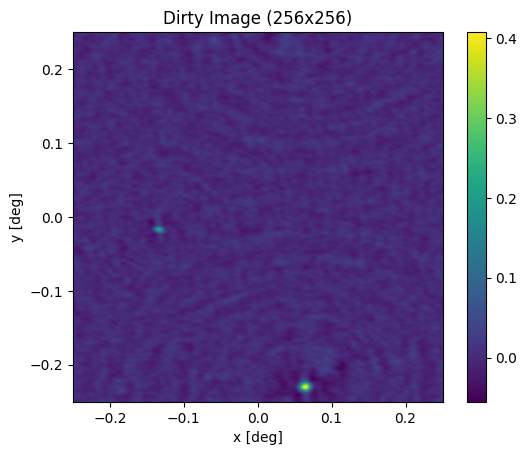

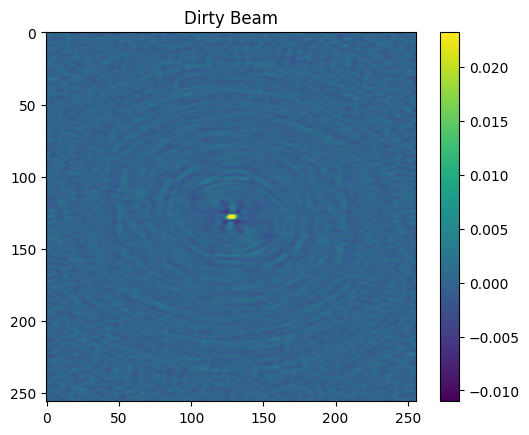

In [ ]:
# Get the dirty image 
obs, dirty_beam = imaging_utils.simulate_dirty_observation(sky_model, uv_tracks, fov, sigma=0.02)

# Plot the dirty image and the beam
plot_utils.plot_sky(obs, fov_size=(fov, fov), title="Dirty Image")
dirty_beam_shifted = np.fft.fftshift(dirty_beam)
plot_utils.plot_beam(dirty_beam_shifted)
#plot_utils.plot_beam(dirty_beam)


plt.title('Dirty Beam')


### Cleaning the observation

We will use the `clean` module to clean the observation. Check the function `hogbom_clean` from the `clean` module.

In [132]:
from argosim.clean import *

Reached threshold at iteration 65


Text(0.5, 1.0, 'cleaned image')

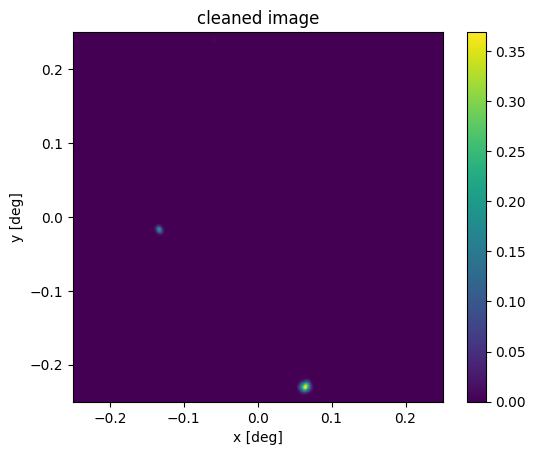

In [133]:
I_clean, sky__model = clean_hogbom(obs, dirty_beam, gamma=0.2, max_iter=100, threshold=1e-3 , clean_beam_size_px=3, res=False)

# Plot the clean image
plot_utils.plot_sky(I_clean, fov_size)
plt.title('cleaned image')




### Metrics

We will use the `metrics` module to evaluate the cleaning. Check the function `compute_metrics` from the `metrics` module.

In [134]:
from argosim.metrics_utils import *

metric: {'mse': np.float64(0.00011939202599988754), 'residual': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(256, 256))}
MSE: 0.000119392026000
MSE (manual): 0.000119392026000
True


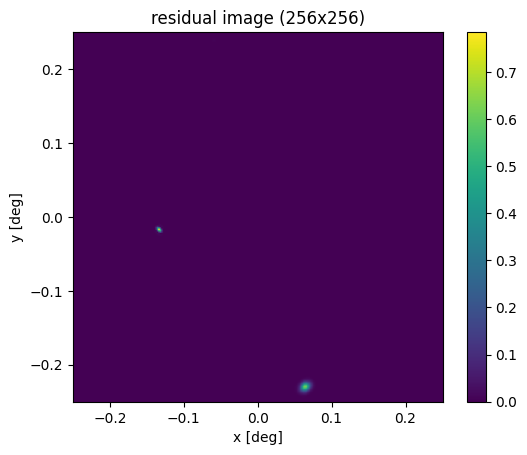

In [135]:
# compute the metrics

metrics = metrics_utils.compute_metrics(I_clean, sky_model)
print("metric:", metrics)


# Plot the residual and check the mse

residual_image = metrics_utils.residual(I_clean, sky_model, True)
plot_utils.plot_sky(residual_image, fov_size=fov_size, title="residual image")

mse_value=metrics_utils.mse(I_clean, sky_model)
print(f"MSE: {mse_value:.15f}")

# Verify that the mse is the mean of the squared residuals

mse_manual = np.mean(residual_image ** 2)

print(f"MSE (manual): {mse_manual:.15f}")

#checking the equality between the two values

assert np.isclose(mse_value, mse_manual), "False"

print("True")
